<a href="https://colab.research.google.com/github/theBuluku/my-data-science-work/blob/master/Xente_Fraud_Detection_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing libaries
#
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler,robust_scale
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,classification_report,recall_score,precision_score,roc_curve
import pandas_profiling as pp
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
#loading training file 
#
df = pd.read_csv("training.csv")
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [ ]:
#loading data dictionary
#
descr = pd.read_csv("Xente_Variable_Definitions.csv")
descr

,Column Name,Definition
0,TransactionId,Unique �transaction identifier on platform
1,BatchId,Unique number assigned to a batch of transacti...
2,AccountId,Unique number identifying the customer on plat...
3,SubscriptionId,Unique number identifying the customer subscri...
4,CustomerId,Unique identifier attached to Account
5,CurrencyCode,Country currency
6,CountryCode,Numerical geographical code of country
7,ProviderId,Source provider of Item �bought.
8,ProductId,Item name being bought.
9,ProductCategory,ProductIds are organized into these broader pr...


In [ ]:
# Previewing some information about the dataset
#
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
TransactionId           95662 non-null object
BatchId                 95662 non-null object
AccountId               95662 non-null object
SubscriptionId          95662 non-null object
CustomerId              95662 non-null object
CurrencyCode            95662 non-null object
CountryCode             95662 non-null int64
ProviderId              95662 non-null object
ProductId               95662 non-null object
ProductCategory         95662 non-null object
ChannelId               95662 non-null object
Amount                  95662 non-null float64
Value                   95662 non-null int64
TransactionStartTime    95662 non-null object
PricingStrategy         95662 non-null int64
FraudResult             95662 non-null int64
dtypes: float64(1), int64(4), object(11)
memory usage: 11.7+ MB


In [ ]:
# Previewing some summary statistics about the dataset
#
df.describe()

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000


In [ ]:
# Checking datatypes of the columns
#
df.dtypes

TransactionId            object
BatchId                  object
AccountId                object
SubscriptionId           object
CustomerId               object
CurrencyCode             object
CountryCode               int64
ProviderId               object
ProductId                object
ProductCategory          object
ChannelId                object
Amount                  float64
Value                     int64
TransactionStartTime     object
PricingStrategy           int64
FraudResult               int64
dtype: object

In [ ]:
# Profile report 
#
pp.ProfileReport(df)

Number of variables,16
Number of observations,95662
Total Missing (%),0.0%
Total size in memory,11.7 MiB
Average record size in memory,128.0 B
Numeric,2
Categorical,9
Boolean,1
Date,0
Text (Unique),1
Rejected,3


In [ ]:
# Checking the number of rows and columns of the dataset
#
df.shape

(95662, 16)

In [ ]:
# Checking the size of values/items of the dataset
#
df.size

1530592

## Data Cleaning

In [ ]:
# Changing the column names to lower
#
df.columns = df.columns.str.lower()
df.columns

Index(['transactionid', 'batchid', 'accountid', 'subscriptionid', 'customerid',
       'currencycode', 'countrycode', 'providerid', 'productid',
       'productcategory', 'channelid', 'amount', 'value',
       'transactionstarttime', 'pricingstrategy', 'fraudresult'],
      dtype='object')

In [ ]:
# Checking and handling null values
#
df.isnull().sum().any()

False

In [ ]:
# Checking for duplicates
#
df.duplicated().any()

False

In [ ]:
# Checking for unique values in each column
#
for column in df.columns:
  print(column)
  print(df[column].nunique())
  print(df[column].unique())
  print('\n')

transactionid
95662
['TransactionId_76871' 'TransactionId_73770' 'TransactionId_26203' ...
 'TransactionId_82501' 'TransactionId_136354' 'TransactionId_35670']


batchid
94809
['BatchId_36123' 'BatchId_15642' 'BatchId_53941' ... 'BatchId_118602'
 'BatchId_70924' 'BatchId_29317']


accountid
3633
['AccountId_3957' 'AccountId_4841' 'AccountId_4229' ... 'AccountId_557'
 'AccountId_2476' 'AccountId_1685']


subscriptionid
3627
['SubscriptionId_887' 'SubscriptionId_3829' 'SubscriptionId_222' ...
 'SubscriptionId_4806' 'SubscriptionId_3567' 'SubscriptionId_84']


customerid
3742
['CustomerId_4406' 'CustomerId_4683' 'CustomerId_988' ... 'CustomerId_893'
 'CustomerId_2892' 'CustomerId_2067']


currencycode
1
['UGX']


countrycode
1
[256]


providerid
6
['ProviderId_6' 'ProviderId_4' 'ProviderId_1' 'ProviderId_5'
 'ProviderId_3' 'ProviderId_2']


productid
23
['ProductId_10' 'ProductId_6' 'ProductId_1' 'ProductId_21' 'ProductId_3'
 'ProductId_15' 'ProductId_11' 'ProductId_19' 'ProductId_4' 'Pro

In [ ]:
df.columns

Index(['transactionid', 'batchid', 'accountid', 'subscriptionid', 'customerid',
       'currencycode', 'countrycode', 'providerid', 'productid',
       'productcategory', 'channelid', 'amount', 'value',
       'transactionstarttime', 'pricingstrategy', 'fraudresult'],
      dtype='object')

In [ ]:
# Changing columns to their appropriate datatypes
#
# Changing transanction startime to datetime format
df.transactionstarttime = pd.to_datetime(df.transactionstarttime)

# list of columns to be changed to categorical datatype
cat_cols = ['providerid', 'productid', 'productcategory', 'channelid','pricingstrategy']

for column in cat_cols:
  df[column] = df[column].astype('category')
  
df.dtypes

transactionid                        object
batchid                              object
accountid                            object
subscriptionid                       object
customerid                           object
currencycode                         object
countrycode                           int64
providerid                         category
productid                          category
productcategory                    category
channelid                          category
amount                              float64
value                                 int64
transactionstarttime    datetime64[ns, UTC]
pricingstrategy                    category
fraudresult                           int64
dtype: object

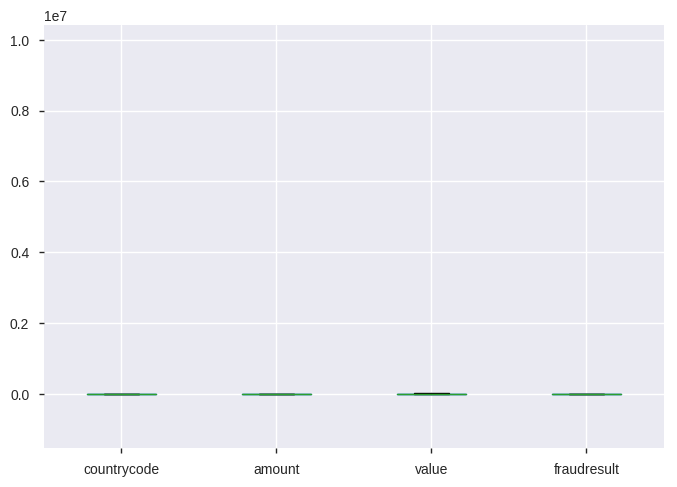

In [ ]:
# checking for outliers
#
df.boxplot()autolib_dataset['DAILY_DATA_POINTS'].plot.hist()
plt.show()autolib_dataset['DAILY_DATA_POINTS'].plot.hist()

## Univariate analysis

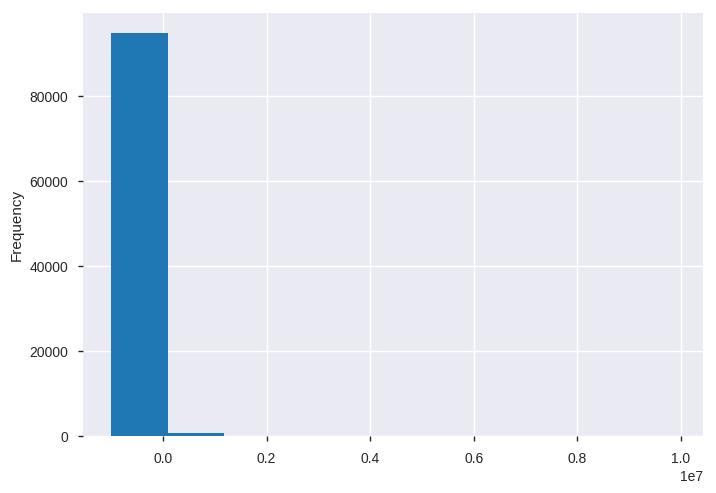

In [ ]:
# plotting histogram of amount varaiable
#
df['amount'].plot.hist()

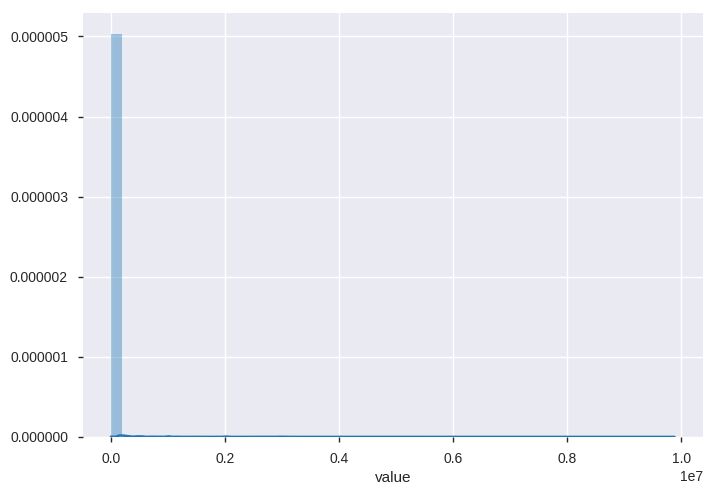

In [ ]:
#  plotting histogram of value variable
#
sns.distplot(df.value)

In [ ]:
# plotting bar chart for product category
#
sns.barplot(df.productcategory,)

TypeError: ignored

In [ ]:
# plotting pie chart for pricing strategy
#
plt.pie(df.pri)